In [1]:
import numpy as np, h5py, pandas as pd
import os
import matplotlib.pyplot as plt
from utils.template_match_target import *
from utils.preprocessing import *
%matplotlib inline

In [4]:
#os.system("mkdir /Users/silburt/remotemount/")
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/final_data/ /Users/silburt/remotemount/")
dirssh = '/Users/silburt/remotemount'
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/r/rein/silburt/moon-craters/datasets/HEAD/ /Users/silburt/remotemount2/")
dirssh2 = '/Users/silburt/remotemount2'
dim=256

In [5]:
def get_csvid(i, zeropad=5):
    return 'img_{i:0{zp}d}'.format(i=i, zp=zeropad)

In [6]:
set = 'HEAD_devpreds_n30000_final'
preds = h5py.File('%s/%s.hdf5'%(dirssh2,set), 'r')
craters = pd.HDFStore('%s/dev_craters.hdf5'%dirssh, 'r')

In [19]:
i=7
craters[get_csvid(i)]

,Diameter (km),Lat,Long,x,y,Diameter (pix)
0,28.521908,2.708153,-7.035614,211.817660,98.139870,106.075160
1,5.226706,3.092622,-7.925918,111.480092,54.802315,19.438522


In [20]:
h5f = h5py.File('sample.h5', 'w')
h5f.create_dataset('csv', data=craters[get_csvid(i)])
h5f.create_dataset('pred', data=preds['dev'][i])
h5f.close()

<HDF5 dataset "pred": shape (256, 256), type "<f4">

In [14]:
pred = h5py.File('sample.h5','r')['pred'][...]
csv = h5py.File('sample.h5','r')['csv'][...].T
csvarr = np.array((csv[3],csv[4], csv[5]/2.)).T
N_match, N_csv, N_templ, maxr, elo, ela, er, csv_dupe_flag = template_match_target_to_csv(pred, csvarr, minrad=8, maxrad=11)
N_match, N_csv, N_templ, maxr, elo, ela, er, csv_dupe_flag

[[111  54   9]]
(array([ 211.81765975,  111.48009211]), array([ 98.13986993,  54.80231549]), array([ 53.03758012,   9.71926093]))


(1,
 2,
 1,
 9,
 0.053343567426528203,
 0.089146165792399756,
 0.079917881447976749,
 [])

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/silburt/remotemount/dev_craters.hdf5
Empty


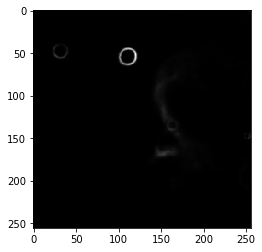

In [18]:
#i=0,2,3 would work
i=7
plt.imshow(preds['dev'][i],origin='upper', cmap="Greys_r")
print craters

In [17]:
#get some data
n_data = 50
set = 'train_images'
imgs = h5py.File('%s/%s.hdf5'%(dir,set), 'r')

Data = {set:[imgs['input_images'][0:n_data].astype('float32'),
             imgs['target_masks'][0:n_data].astype('float32')]}

preprocess(Data)

In [18]:
for i in range(n_data):
    vmin=0
    l=imgs['pix_bounds'][get_csvid(i)]

    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20, 6])
    ax1.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="Greys_r")
    ax1.imshow(Data[set][1][i],origin='upper', cmap="Greys_r",alpha=0.2)
    ax1.set_title('rawlen=%d'%(l[3]-l[1]))
    cbr = ax2.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="rainbow",vmin=vmin, vmax=1)
    plt.colorbar(cbr)
    ax2.set_title('showing pixels > %.2f'%vmin)
    ax3.plot(Data[set][0][i].reshape(dim*dim), '.')
    ax3.plot([0,dim*dim],[vmin,vmin],'k--')
    ax3.set_ylim([0,1])
    plt.savefig('output_dir/images/HEAD_img%d.png'%i)
    plt.close()

In [83]:
from keras.models import load_model
model = load_model('models/HEAD.h5')
preds = model.predict(Data[set][0])

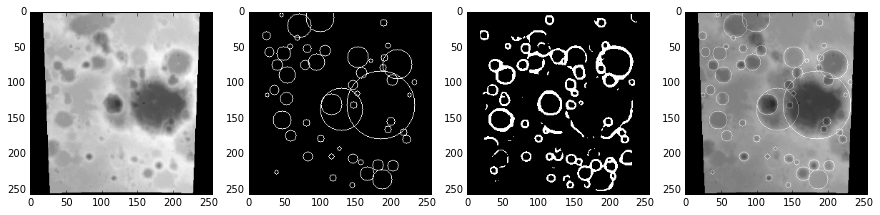

In [98]:
i=6
vmin=0.5
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[15, 5])
ax1.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="Greys_r", vmin=vmin, vmax=1)
ax2.imshow(Data[set][1][i],origin='upper', cmap="Greys_r")
ax3.imshow(preds[i],origin='upper', cmap="Greys_r")
ax4.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="Greys_r", vmin=vmin, vmax=1)
ax4.imshow(Data[set][1][i],origin='upper', cmap="Greys_r", alpha=0.25)

In [37]:
## Compare to old Salamuniccar dataset
test = np.load('datasets/rings/Test_rings/test_data_50im.npy')

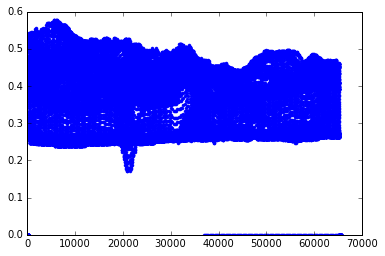

In [109]:
i=1
plt.plot(test[i].reshape(dim*dim),'.')
#plt.imshow(test[i].reshape(dim,dim),origin='upper', cmap="Greys_r",)
plt.savefig('output_dir/images/test_pix.png')

## Test out template matching

In [70]:
craters = pd.HDFStore('%s/dev_craters.hdf5'%dir, 'r')

In [71]:
# get csvs
csvs = []
minrad, maxrad, cutrad, n_csvs = 2, 50, 1, 10
for i in range(n_csvs):
    csv = craters[get_csvid(i)]
    # remove small/large/half craters
    csv = csv[(csv['Diameter (pix)'] < 2*maxrad) & (csv['Diameter (pix)'] > 2*minrad)]
    csv = csv[(csv['x']+cutrad*csv['Diameter (pix)']/2 <= dim)]
    csv = csv[(csv['y']+cutrad*csv['Diameter (pix)']/2 <= dim)]
    csv = csv[(csv['x']-cutrad*csv['Diameter (pix)']/2 > 0)]
    csv = csv[(csv['y']-cutrad*csv['Diameter (pix)']/2 > 0)]
    if len(csv) < 3:    #exclude csvs with tiny crater numbers
        csvs.append([-1])
    else:
        csv_coords = np.asarray((csv['x'],csv['y'],csv['Diameter (pix)']/2)).T
        csvs.append(csv_coords)

In [93]:
csvs[0]

array([[ 165.04738615,  228.2596605 ,   10.1397238 ],
       [  93.73022006,  193.74566953,   36.70400969],
       [ 181.69617957,  190.9058804 ,    9.04334095],
       [  76.95213561,  175.34437791,    5.63035655],
       [  89.35104515,  132.90521727,    8.65899257],
       [ 137.71229956,  114.67250516,    8.40141063],
       [ 194.41660867,   99.887924  ,   13.41164418],
       [ 191.65215929,   34.53992073,    4.97180596],
       [  97.36927443,   24.39456619,   10.99302142],
       [ 203.07517832,   20.60837833,    6.92728796],
       [ 181.14743033,   19.6435302 ,    4.26401857],
       [  60.27752231,   17.92669804,    4.78896427]])

In [96]:
i=6
N_match, N_csv, N_templ, maxr, csv_dupe_flag = template_match_target_to_csv(preds[i], csvs[i])

In [97]:
N_match, N_csv, N_templ, maxr, csv_dupe_flag

(28, 53, 33, 15, 0)

## Mercury

In [4]:
preds = np.load('datasets/mercury/merc_preds.npy')
imgs = np.load('datasets/mercury/merc_0_input.npy')

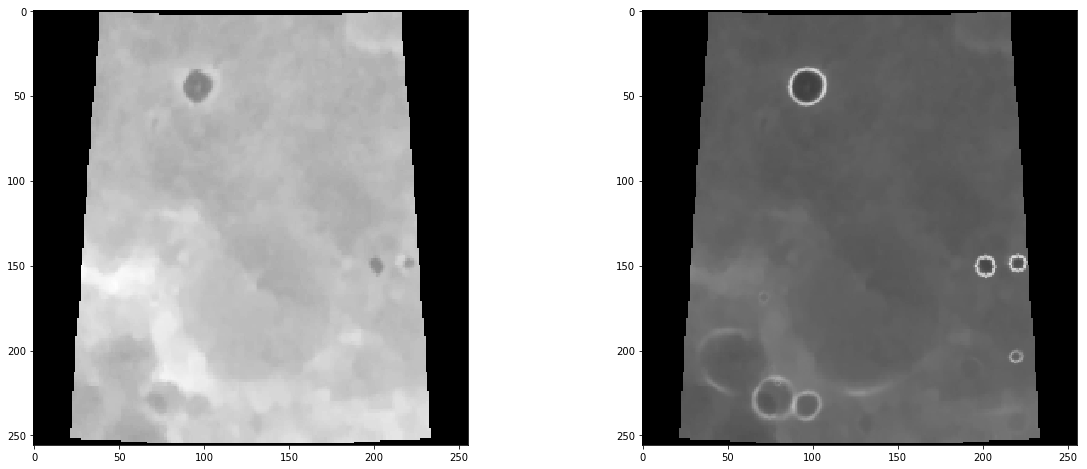

In [6]:
i=0
f, (ax1, ax2) = plt.subplots(1,2, figsize=[20, 8])
ax1.imshow(imgs[i],origin='upper', cmap="Greys_r")
ax2.imshow(imgs[i],origin='upper', cmap="Greys_r")
ax2.imshow(preds[i],origin='upper', cmap="Greys_r",alpha=0.5)